## Hands-On ML with Scikit-Learn

Taken from Geron, A. (2023). Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow. O'Reilly: 3rd edition.

### Chapter 2. End-to-End Machine Learning Project

1. Look at the big picture

2. Get the data

3. Explore and visualize the data to gain insights

4. Prepare the data for ML algorithms

5. Select a model and train it

6. Fine-tune your model

7. Present your solution

8. Launch, monitor and maintain your system


**Working with real data**:

* [OpenML.org](https://openml.org/)

* [Kaggle](https://www.kaggle.com/datasets)

* [PapersWithCode.com](https://paperswithcode.com/datasets)

* [UC Irvine ML repo](https://archive.ics.uci.edu/)

* [Amazon AWS datasets](https://registry.opendata.aws/)

* [TensorFlow datasets](https://www.tensorflow.org/datasets)

* [DataPortals (Meta-portal)](https://dataportals.org/)

* [Open Data Monitor (Meta-portal)](https://opendatamonitor.eu/frontend/web/index.php?r=dashboard%2Findex)

### The Project: Housing Prices in California

#### 1. Look at the big picture

Use California census data to **build a model of housing prices in the state**. 

This data includes metrics such as the population, median income, and median housing price for each *block group* ('district') in California.

Your model **should learn from this data and be able to predict the median housing price** in any district, given all the other metrics.

##### Frame the Problem

* *Know the objective*:

The first question you and your customer should ask is: *How does the company expect to use and benefit from this model?*

This will help you frame the problem, select algorithms and performance measures and how much effort you will spend teaking it.

Your customer answers that your model's output (a prediction of a district's median housing price) will be fed to another ML system (see Figure 2-2). This downstream system will determin whether it is worth investing in a given area.

![](https://abhijitramesh.me/static/images/part2-learning-hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/Screenshot_2021-03-05_at_1.17.49_PM.png)

* *Know the current situation*:

The next question is: *What does the current situation look like?*

This will give you a reference for performance, as well as insights on how to solve the problem.

Your customer answers that the district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district and they estimate it using complex rules.

* *Design your solution*

Finally, ask: *What kind of training supervision the model will need? Is it a classification, regression or reinforcement learning task? Should I use batch learning or online learning techniques?...*

The solution required in this case is a typical **regression task**, since the model is asked to predict a value:

* Multiple regression: multiple features are required to make a prediction

* Univariate regression: model only predicts a single value for each district

* Plain batch learning: there is no continuous flow of data coming into the system and no particular need to adjust to changing data rapidly. Data set is also small enough to fit in memory.

##### Pipelines

A *Pipeline* is a sequence of data processing components. Pipelines are very common in ML systems, since there is a lot of data to manipulate and many data transformations to apply.

Components typically run asynchronously.

* Each component pulls in a large amount of data, processes it and spits out the result in another data store.

* Then, some time later, the next component in the pipeline pulls in this data and spits out its own output.

* Each component is fairly self-contained: the interface between components is simply the data store.

##### Select Performance Measures

A typical performance measure for regression problems is the **Root Mean Square Error (RMSE)**. 

$$
RMSE(\mathbf{X}, h) = \sqrt{\frac{1}{m}\sum_{i=1}^m\big(h(\mathbf{x}^{(i)}-y^{(i)}\big)^2}
$$

where,

$m$ = the number of instances in the dataset. For example, if you are evaluating the RMSE on a validation set of 2000 districts, then $m=2,000$

$\mathbf{x}^{(i)}$ = a vector of all the feature values (excluding the label) of the $i$-th instance in the dataset.

$y^{(i)}$ = the label or desired output value for that instance.

* For example, if the 1st district in the dataset is located at longitude $-118.29^{\circ}$, latitude $33.91^{\circ}$, and it has $1,416$ inhabitants with a median income of $\$38,372$, and the median house value is $\$156,400$ (ignoring other features for now). Then,

$$
\mathbf{x}^{(1)} = 
\begin{pmatrix}
-118.29\\
33.91\\
1,416\\
38,372
\end{pmatrix}
$$

and 

$$
y^{(1)} = 156,400
$$

$\mathbf{X}$ = a matrix containing all the feature values (excluding labels) of all instances in the dataset. There is one row per instance, and the $i$-th row is equal to the *transpose* of $\mathbf{x}^{(i)}$, noted as $(\mathbf{x}^{(i)})^\top$

* For example, if the first district is as just described, then the matrix $\mathbf{X}$ looks like this:

$$
\mathbf{X} = 
\begin{pmatrix}
(\mathbf{x}^{(1)})^\top\\
(\mathbf{x}^{(2)})^\top\\
\vdots\\
(\mathbf{x}^{(m-1)})^\top\\
(\mathbf{x}^{(m)})^\top\\
\end{pmatrix}
=
\begin{pmatrix}
-118.29 & 33.91 & 1,416 & 38,372\\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}
$$

$h$ = your system's prediction function: *hypothesis*. That is, the predicted value of your system: $\hat{y}^{(i)}=h(\mathbf{x}^{(i)})$.

* For example, if your system predicts that the median housing price in the first district is $\$158,400$, then $\hat{y}^{(1)}=158,400$. The prediction error for this district is $\hat{y}^{(1)} - y^{(1)} = 2,000$

Another performance measure used is the **Mean Absolute Error (MAE)** or average absolute deviation:

$$
MAE(\mathbf{X},h) = \frac{1}{m}\sum_{i=1}^m \big|h(\mathbf{x}^{(i)}-y^{(i)})\big|
$$

Both the RMSE and the MAE are ways to measure *the distance between two vectors*: the vector of predictions and the vector of target values.

Various distance measures or *norms* are possible:

* **Euclidean norm**: Computing the root of a sum of squares, like in RSME. It is also called the $\ell_2$ norm and noted using $\parallel\cdot\parallel$

* **Manhattan norm**: Computing the sum of absolutes, like in MAE. It is also called the $\ell_1$ norm. 

#### 2. Get the Data

In typical environments, your data would be available in a relational database or some other common data store, and spread accross multiple tables/documents/files.

In this project, you will just download a single compressed file *housing.tgz* which contains a comma-separated values (`.csv`) file called *housing.csv* with all the data.

In [1]:
############## Getting the data ##############
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Load data
def load_housing_data(url):
    
    tarball_path = Path('datasets/housing.tgz')

    # Retrieve tarball from url
    urllib.request.urlretrieve(url, tarball_path)

    # Open tar file
    with tarfile.open('datasets/housing.tgz') as housing_tarball:
        housing_tarball.extractall(path='datasets')

    return pd.read_csv('datasets/housing/housing.csv')

In [2]:
# Load housing data from URL
url = "https://github.com/ageron/data/raw/main/housing.tgz"

housing = load_housing_data(url)

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##### Get a Quick Look at Data

Use the `.info()` method to get a quick description of the data:

In [3]:
# Get a quick description of the dataset
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* There are $20,640$ instances in the dataset, which is fairly small for ML standards.

* `total_bedrooms` attribute has only $20,433$ non-null values, meaning that $207$ districts are missing this feature.

* All attributes are numerical, except for `ocean_proximity`, which is a categorical attribute.

In [4]:
# Check categories for `ocean_proximity`
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Use the `.describe()` method to show a summary of the numerical attributes:

In [5]:
# Show a summary of numerical data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot a histogram to show the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

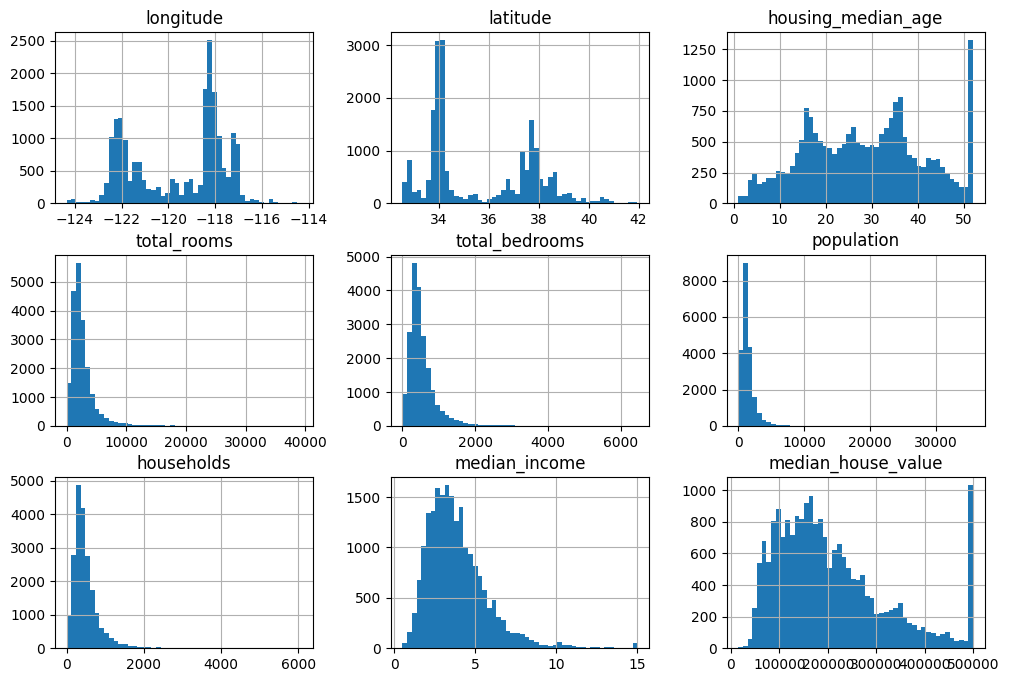

In [6]:
%matplotlib inline
housing.hist(bins=50, figsize=(12,8))

* `median_income` attribute does not look like it is expressed in USD. After checking, your client team says that the data has been *scaled and capped* at 15 (15.0001) for higher median incomes and at 0.5 (0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., $3$ actually means $\$30,000$).

* `housing_median_age` and `median_house_value` were also capped at $\$500,000$. The latter may be a serious problem since it is your *target* attribute (labels). Your ML algorithms may learn that prices never go beyond that limit.

    - If this is a problem, you need to collect proper labels for the districts whose labels were capped

    - Or remove those districts from the training set (and the test set) since your system should not be evaluated poorly if it predicts values beyond $\$500,000$.

* Attributes have very different scales: We will need to do *feature scaling*.

* Many histograms are *skewed right*. This may make it a bit harder for some ML algorithms to detect patterns. We will need to *transform* these attributes to have more symmetrical and bell-shaped distributions.

##### Create a Test Set

Creating a test set at this stage prevents your brain from detecting some interesting pattern in the test data that leads you to select a particular kind of ML model (and therefore, prone to *overfitting*). This is called **data snooping** bias.

**Random Shuffle**

To create a test set, usually pick 20% of the dataset randomly (or less if your dataset is very large):

In [7]:
############## Creating Training/Test Sets ##############
import numpy as np

def shuffle_and_split(data, test_ratio):

    # Find random indices and test set size
    shuffled_inds = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)

    # Filter indices for test set
    test_inds = shuffled_inds[:test_set_size]
    train_inds = shuffled_inds[test_set_size:]

    return data.iloc[train_inds], data.iloc[test_inds]

In [8]:
# Split the dataset
train_set, test_set = shuffle_and_split(housing, 0.2)

print(f'Training set of {len(train_set)} values')
print(f'Test set of {len(test_set)} values')

Training set of 16512 values
Test set of 4128 values


The problem with this implementation is that if you run the program again, it will generate a different test set every time! Eventually, you or your ML algorithm will get to see the whole dataset, which is what you want to avoid.

To avoid this, you can:

* Save the test set on the first run and then load it in subsequent runs.

* Set a random number generator's seed, e.g. `np.random.seed(42)` before calling the `np.random.permutation()` method.

Both solutions will break next time you fetch an updated dataset.

**Using identifiers**:

To have a stable train/test split:

* Use each instance's identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers)

* You can compute a hash of each instance's id and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value.

* Use `crc32` method from the `zlib` module to compute the checksum for crc32 (Cyclic Redundancy Check) to a particular data. It will give 32-bit integer value as a result.

In [9]:
from zlib import crc32

print(crc32(np.int64(55)))

test_ratio = 0.2

print(2**32)

3928655117
4294967296


In [10]:
# Split dataset using ids
import numpy as np
from zlib import crc32

# Filter dataset using id
def is_id_in_test(id, test_ratio):

    return crc32(np.int64(id)) < test_ratio * 2**32

# Split data with id hash
def split_data_with_id(data, test_ratio, id_col):
    
    ids = data[id_col]
    in_test_set = ids.apply(lambda id: is_id_in_test(id, test_ratio))

    return data.loc[~in_test_set], data.loc[in_test_set] # ~ not in

For our case, the housing dataset does not have an id column. The simplest solution is to use the row index as the id:

In [11]:
# Split data using index as id
housing_with_id = housing.reset_index() # adds `index` col
train_set, test_set = split_data_with_id(housing_with_id, 0.2, 'index')

print(f'Training set of {len(train_set)} values')
print(f'Test set of {len(test_set)} values')

Training set of 16512 values
Test set of 4128 values


**Using `scikit-learn`**:

* Random sampling:

The function `train_test_split()` does pretty much the same thing as the `shuffle_and_split()` function we defined earlier.

In [12]:
# Split dataset using `sklearn` module
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f'Training set of {len(train_set)} values')
print(f'Test set of {len(test_set)} values')

Training set of 16512 values
Test set of 4128 values


* Stratified sampling:

Sometimes we may want to ensure that all groups in the population are representative, especially when working with small datasets. For example, the US population is 51.1% females and 48.9% males, so we may want to maintain this ratio in the sampling.

* Thus, the population is divided into homogeneous subgroups: *strata*

* And the right number of instances are sampled from each stratum to guarantee that the test set is representative of the *overall population*.

Assume the client has mentioned that the `median_income` is a very important attribute to predict median housing prices.

Then, you want to **make sure that the test set is representative of the various categories** of incomes in the whole dataset.

Let's check again the histogram for `median_income`:

<Axes: >

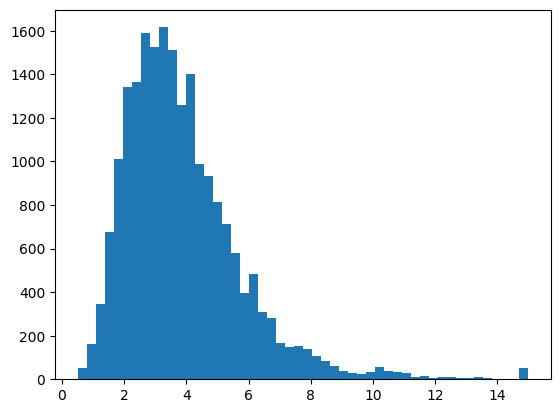

In [13]:
housing.median_income.hist(bins=50, grid=False)

* As shown in the histogram, most of median income values are clustered around 1.5 to 6 (i.e., $\$15,000-\$60,000$), but some median incomes go far beyond 6.

* So, we need to create an income category attribute with five categories (1 to 5), where category 1 ranges between 0 and 1.5 (i.e., less than $\$15,000$), category 2 from 1.5 to 3, and so on, using `pd.cut()` method.

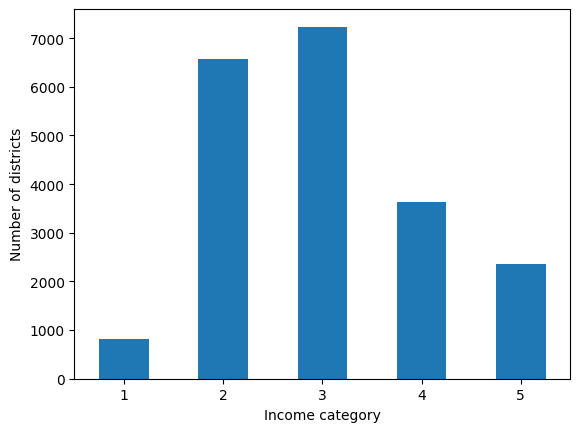

In [14]:
# `Cut` median income into 5 categories
import matplotlib.pyplot as plt

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

# Plot the number of districts per category
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=False)
plt.xlabel('Income category')
plt.ylabel('Number of districts')
plt.show()

* `scikit-learn` provides various strategies to split data. You can use `StratifiedShuffleSplit` or add the argument `stratify` to the previous `train_test_split()` method.

In [15]:
# Using `StratifiedShuffleSplit`
from sklearn.model_selection import StratifiedShuffleSplit

# Use StratifiedShuffleSplit as splitter
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

# Find indices for train/test for 10 splits
for train_ind, test_ind in splitter.split(housing, housing['income_cat']):
    
    strat_train_set = housing.iloc[train_ind]
    strat_test_set = housing.iloc[test_ind]

    strat_splits.append([strat_train_set, strat_test_set])

# Use the first split for now
train_set_strat, test_set_strat = strat_splits[0]

print(f'Training set of {len(train_set_strat)} values')
print(f'Test set of {len(test_set_strat)} values')

Training set of 16512 values
Test set of 4128 values


In [16]:
# Using `train_test_split(stratify=)`
train_set_strat, test_set_strat = train_test_split(housing, 
                                                   test_size=0.2,
                                                   stratify=housing['income_cat'],
                                                   random_state=42)

# Check if it works as expected
test_set_strat['income_cat'].value_counts()/len(test_set_strat)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

You won't use the `income_cat` column again, so we may drop it:

In [17]:
for s in (train_set_strat, test_set_strat):
    s.drop('income_cat', axis=1, inplace=True)

In [18]:
print(train_set.columns)
print(test_set.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


#### 3. Explore and Visualize Data

In [19]:
# Create a copy of the train set
housing = train_set_strat.copy()

##### Visualize Geographical Data

Use `longitude` and `latitude` data to plot geographical data:

<Axes: xlabel='longitude', ylabel='latitude'>

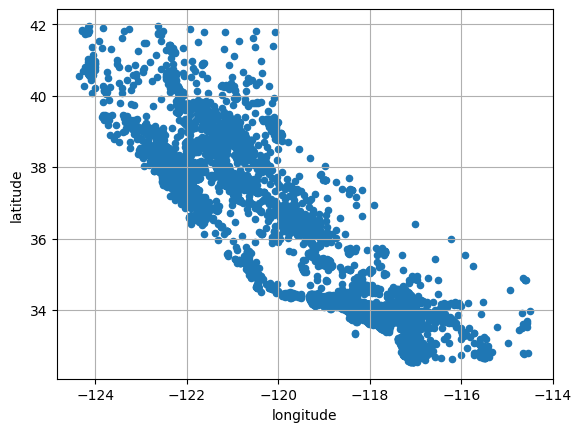

In [20]:
%matplotlib inline
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)

Set `alpha=0.2` to easily visualize the places where there is a high density of data points:

<Axes: xlabel='longitude', ylabel='latitude'>

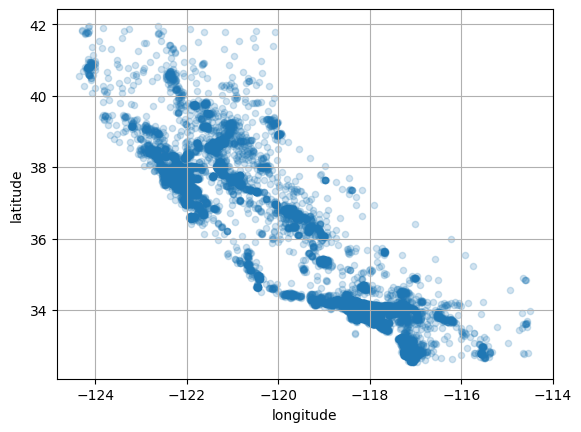

In [21]:
%matplotlib inline
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)

You can improve the understanding of the visualization by modifying the radius of each circle `s` according to the district's population, and the color `c` according to the price. Use `cmap=jet` to range from blue (low values) to red (high values):

<Axes: xlabel='longitude', ylabel='latitude'>

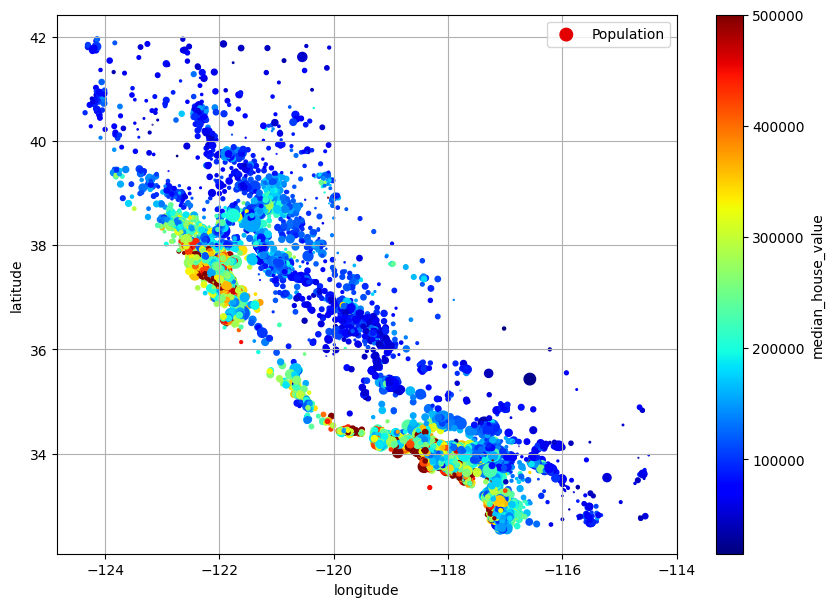

In [22]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population']/100, label='Population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

##### Look for Correlations

Compute the *Standard Correlation Coefficient* (Pearson's r):

In [23]:
corr_matrix = housing.loc[:, housing.columns != 'ocean_proximity'].corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

You can visualize correlations using the `scatter_matrix` method in `pandas`:

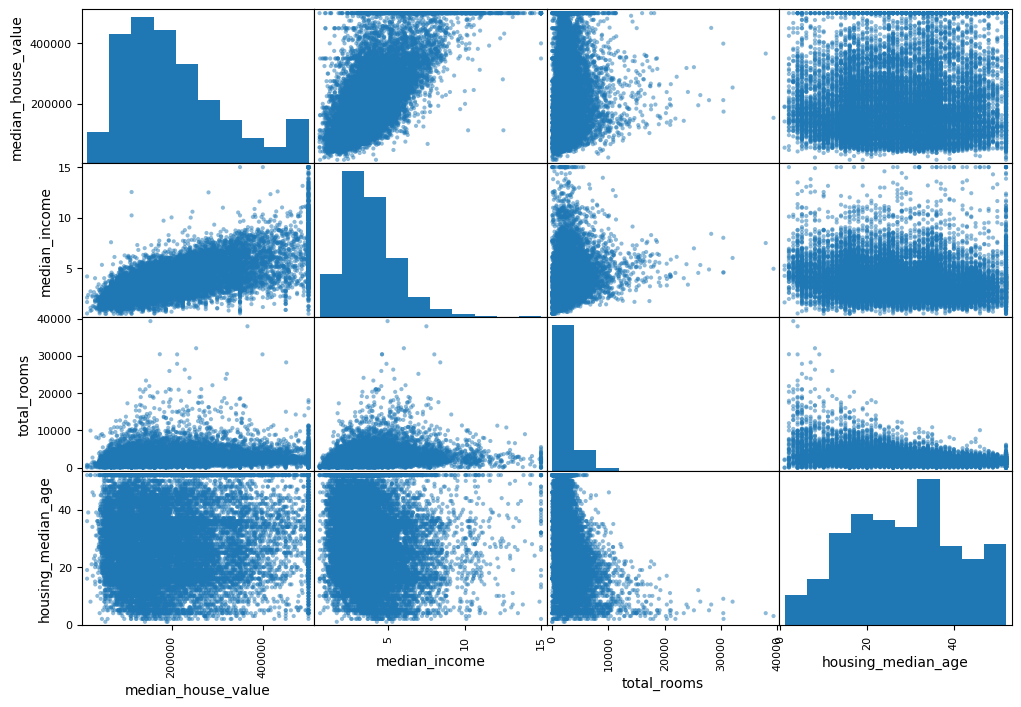

In [24]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Looking at the correlation scatterplots, it seems like the most promising attribute to predict the median house value is the `median_income`:

<Axes: xlabel='median_income', ylabel='median_house_value'>

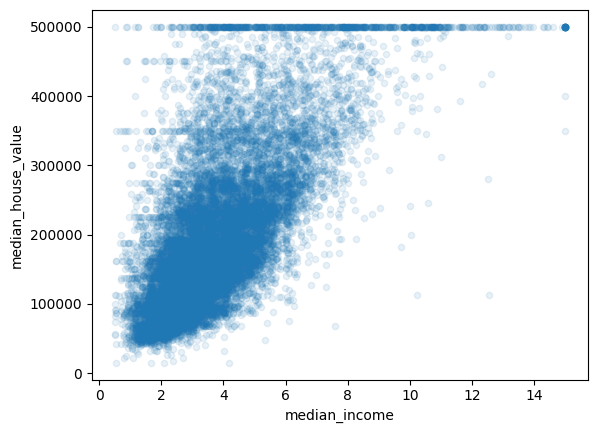

In [25]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

##### Experiment with Attribute Combinations

Try out various attribute combinations. 

* For example, the total number of rooms `total_rooms` in a district is not very useful if you don't know how many households there are. What you really want is the number of rooms per household.

* Similarly, the total number of bedrooms `total_bedrooms` by itself is not very useful. You probably want to compare it to the number of rooms.

* Population `population` per household also seems like an interesting attribute combination to look at.

In [26]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [27]:
housing['rooms_per_house'] = housing['total_rooms']/housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house'] = housing['population']/housing['households']

In [28]:
corr_matrix = housing.loc[:, housing.columns != 'ocean_proximity'].corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The new `bedrooms_ratio` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently, houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district.

#### 4. Prepare the Data for ML Algorithms

##### Clean the Data

Prepare some functions to:

* Reproduce transformations easily on any dataset

* Build a library of transformation functions to reuse in future projects

* Use these functions in your live system to transform the new data before feeding it to your algorithms

* Easily try various transformations and see which combination of transformations works best.

First, separate the predictors and the labels by creating copies from the original training set:

In [29]:
# Separate and copy attributes and labels
housing = train_set_strat.drop('median_house_value', axis=1)
housing_labels = train_set_strat['median_house_value'].copy()

Second, fix the attribute `total_bedrooms` which has missing values:

* Get rid of the corresponding districts: `.dropna()`

* Get rid of the whole attribute: `.drop()`

* Set the missing values to some value (zero, the mean, the median, etc.): *Imputation*

Let's do the last one, as it is the lest destructive:

In [30]:
# Replace NaNs with the median
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

You can also use `SimpleImputer` from `scikit-learn`:

In [31]:
from sklearn.impute import SimpleImputer

# Select imputer to be the `median`
imputer = SimpleImputer(strategy='median')

# Copy the data with only numerical attributes (to apply the median)
housing_num = housing.select_dtypes(include=[np.number])

# Fit the imputer instance to the training data
imputer.fit(housing_num)

# Show the `median` values for all attributes
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [32]:
# Check with median values
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Use the "trained" imputer to transform the training set by replacing missing values with the learned medians:

In [33]:
X = imputer.transform(housing_num)

Other available imputers include:

* `KNNImputer`: replaces each missing value with the mean of the $k$-nearest neighbors' values for that feature. The distance is based on all the available features.

* `IterativeImputer`: trains a regression model per feature to predict the missing value based on all the other available features. It then trains the model again on the updated data and repeats the process several times, improving the models and the replacement values at each iteration.

In [34]:
# Wrap X in a DataFrame again
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [1]:
def a():
    pass

In [2]:
type(a)

function

In [3]:
5//2

2

In [5]:
a = {1: 9}
a.items()

dict_items([(1, 9)])

In [8]:
try:
    [1, 2, 3][4]
except IndexError:
    print("""IndexError raised""")
except:
    print("""Exception raised""")
else:
    print("""something else
          happened""")
finally:
    print("""Cleaning Up""")

IndexError raised
Cleaning Up


In [9]:
a = 7
a.__strt__()

AttributeError: 'int' object has no attribute '__strt__'

In [10]:
a = {4:6}
a.get(6)

In [11]:
a

{4: 6}

In [12]:
print(a.get(6))

None


In [13]:
print('Hello' 'world' * 2)

HelloworldHelloworld


In [14]:
class test():
    id = 0
    def __init__(self, id):
        self.id = id
        id = 2

In [15]:
t = test(1)
t.id

1

In [17]:
import regex as re

In [18]:
m = re.search(r'(ab[cd]?)', "acdeabdabcde")

In [19]:
m.groups()

('abd',)

In [20]:
import sys
sys.path

['g:\\My Drive\\GitHub\\course-data-structures-py',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310',
 '',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\sebastiancg\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin']

In [23]:
import datetime

type(datetime.date(2012, 1, 1) - datetime.date(2011, 1, 1))

datetime.timedelta

In [24]:
import itertools

[i for i in filter(lambda x: x%5, itertools.islice(itertools.count(5), 10))]

[6, 7, 8, 9, 11, 12, 13, 14]